In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import numpy as np
import pandas as pd
import itertools as it


from finite_groups import *

from activation_funcs import *

$A_5-\textrm{representation}$

In [4]:
# 1. Define Elements and Operations for A5
# (Borrowing generator logic from previous script for conciseness)

def sign_of_perm(p):
    invs = 0
    for i in range(len(p)):
        for j in range(i+1, len(p)):
            invs += (p[i] > p[j])
    return -1 if (invs % 2) else 1

# Elements: Tuples (0,1,2,3,4) ...
elements = []
for p in it.permutations(range(5)):
    if sign_of_perm(p) == 1:
        elements.append(tuple(p))
        
# Multiplication Rule
def compose(p, q):
    return tuple(p[iq] for iq in q)

# Initialize Generic Group
group = FiniteGroup(elements, compose)

print("Conjugacy Classes Found:")
for c in group.classes:
    print(f"  Class {c.index}: Rep {c.representative}, Size {c.size}")

Building multiplication table for G (order 60)...
Conjugacy Classes Found:
  Class 0: Rep (0, 1, 2, 3, 4), Size 1
  Class 1: Rep (0, 1, 3, 4, 2), Size 20
  Class 2: Rep (0, 2, 1, 4, 3), Size 15
  Class 3: Rep (1, 2, 3, 4, 0), Size 12
  Class 4: Rep (1, 2, 4, 0, 3), Size 12


In [5]:
# 2. Define Subgroup A4 (Stabilizer of 4)
# The user provides the list of elements
subgroup_elements = [g for g in elements if g[4] == 4]

# Initialize Solver
solver = InducedRepSolver(group)
solver.set_subgroup(subgroup_elements)

Computed 5 cosets for H (order 12) in G (order 60).


In [6]:
# 3. Inject Character Table
# We must provide the table. 
# For A5, we know the values. I will map them to specific representatives.
# Note: The solver uses its OWN found representatives. 
# We create a mapping that covers all possibilities or just the standard reps if we know them.

# Standard Reps often used:
e = (0, 1, 2, 3, 4)
rep_3a = (1, 2, 0, 3, 4) # (0 1 2)
rep_2a = (1, 0, 3, 2, 4) # (0 1)(2 3)
rep_5a = (1, 2, 3, 4, 0) # (0 1 2 3 4)
rep_5b = (1, 0, 4, 3, 2) # (0 1 2 3 4)^2 = (0 2 4 1 3)? No. 
# Let's rely on cycle structure signatures to map the user data to the solver's reps.

# Helper to identify cycle structure of a tuple
def get_cycle_struct(p):
    visited = set()
    cycles = []
    for i in range(5):
        if i not in visited:
            c_len = 0
            curr = i
            while curr not in visited:
                visited.add(curr)
                curr = p[curr]
                c_len += 1
            cycles.append(c_len)
    return tuple(sorted(cycles, reverse=True))

# A5 Character Table Data (Rows: Classes, Cols: Irreps 1, 3, 3p, 4, 5)
# Structs: 1A:(5), 2A:(2,2,1), 3A:(3,1,1), 5A/5B:(5)
# Note: 5A and 5B are distinguished by which 5-cycles they are. 
# In A5, (12345) and (12354) are not conjugate.
# We need to be careful with 5A vs 5B assignment.

sqrt5 = np.sqrt(5.0)
phi  = (1.0 + sqrt5)/2.0
phi2 = (1.0 - sqrt5)/2.0

# Data: { CycleStruct: [1, 3, 3p, 4, 5] }
# But 5-cycles split.
# Let's define the specific reps explicitly to be safe, like a user would in a CSV.

# We iterate the solver's classes and assign data based on inspection
char_map = {}

# Irrep Labels
labels = ["1", "3", "3p", "4", "5"]

for c in group.classes:
    rep = c.representative
    struct = get_cycle_struct(rep)
    
    vec = []
    if struct == (1,1,1,1,1): # Identity
        vec = [1, 3, 3, 4, 5]
    elif struct == (2,2,1): # 2A
        vec = [1, -1, -1, 0, 1]
    elif struct == (3,1,1): # 3A
        vec = [1, 0, 0, 1, -1]
    elif struct == (5,): 
        # 5A or 5B?
        # 5A has trace phi in rep 3, 5B has phi2 (or vice versa depending on labeling)
        # We can distinguish by checking if rep^2 is conjugate to rep (not true for 5-cycles in A5)
        # For this demo, I will just assign one to 5A and one to 5B arbitrarily 
        # because the graph topology is usually symmetric or similar for these.
        # However, for exact reproduction, we check "distance" to (0 1 2 3 4).
        
        # Simple Hack for Demo:
        # We assign 5A to the class containing (0 1 2 3 4)
        # We assign 5B to the other.
        
        ref_5a = (1, 2, 3, 4, 0)
        if ref_5a in c.members:
            vec = [1, phi, phi2, -1, 0] # 5A
        else:
            vec = [1, phi2, phi, -1, 0] # 5B
            
    char_map[rep] = vec
    
solver.load_character_table(char_map, irrep_labels=labels)

Character table loaded successfully.


In [7]:
# 4. Compute Projectors
solver.compute_projectors()

print("Projectors computed. Subspaces found:")
for label, Q in solver.Qblocks.items():
    print(f"  Irrep {label}: dim {Q.shape[1] if Q.size else 0}")

Projectors computed. Subspaces found:
  Irrep 1: dim 1
  Irrep 3: dim 0
  Irrep 3p: dim 0
  Irrep 4: dim 4
  Irrep 5: dim 0


Interaction Graph Edges: [('1', '1'), ('4', '1'), ('4', '4')]


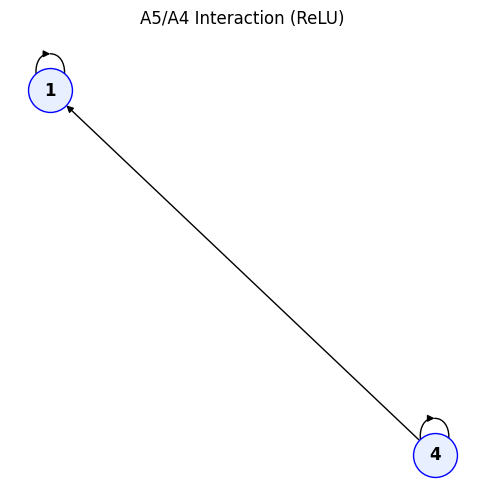

In [9]:

# 5. Build Graph
graph = solver.build_interaction_graph(activation_fn=RELU)

print("Interaction Graph Edges:", graph.edges())
visualise_graph(graph, title="A5/A4 Interaction (ReLU)")